[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\SUSHANT\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


8816


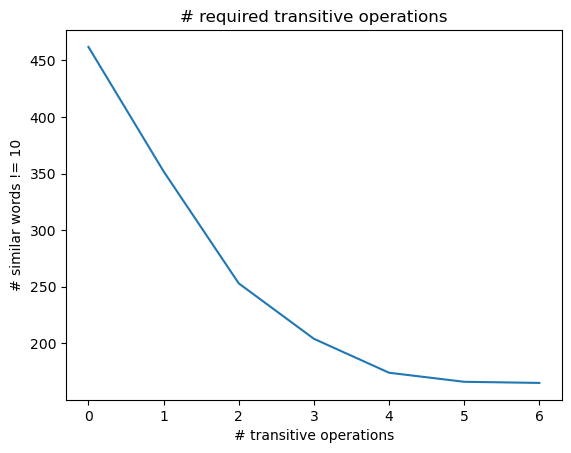

mean ndcg ws:1,vs:10: 0.005189229379857639


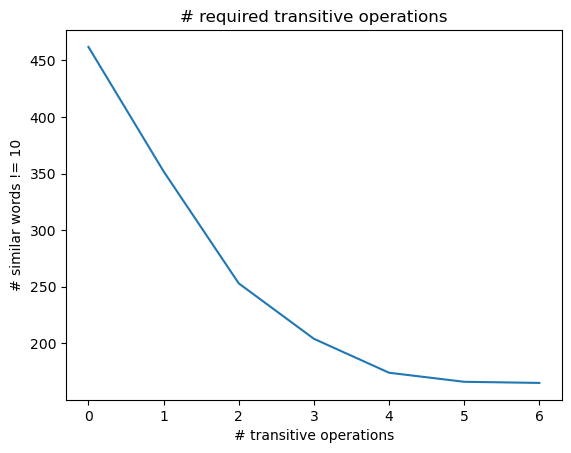

mean ndcg ws:1,vs:50: 0.006883540857994439


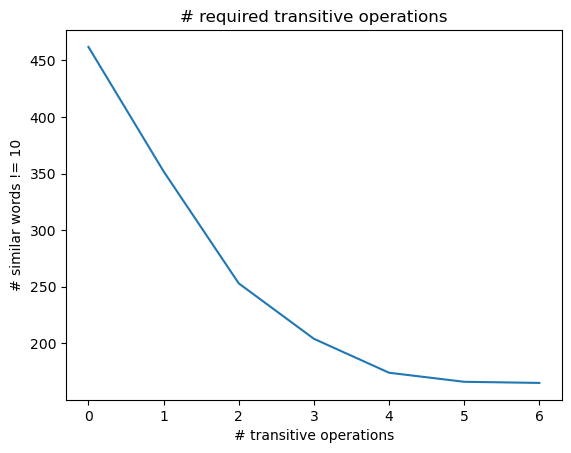

mean ndcg ws:1,vs:100: 0.006017292361004736


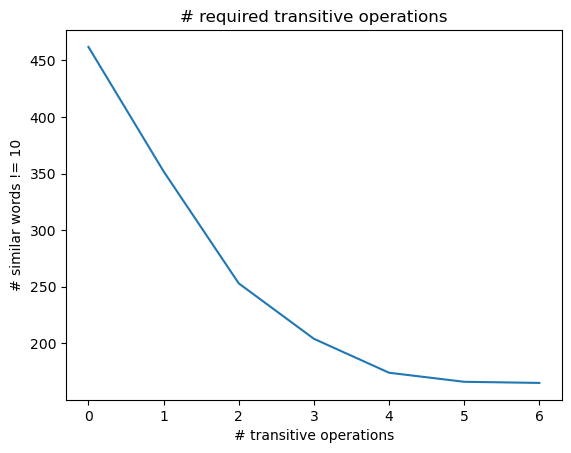

mean ndcg ws:1,vs:300: 0.00616643242945381


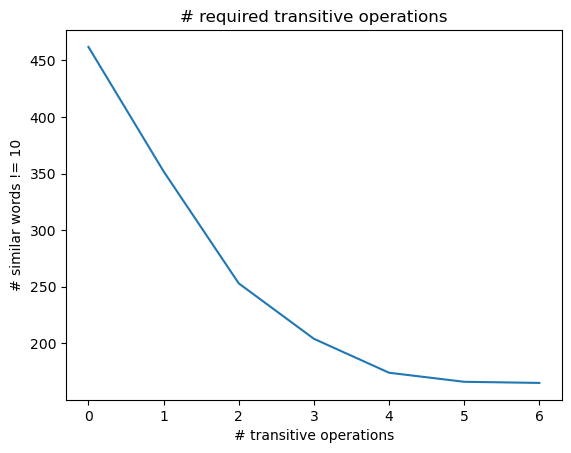

mean ndcg ws:2,vs:10: 0.004641497601891277


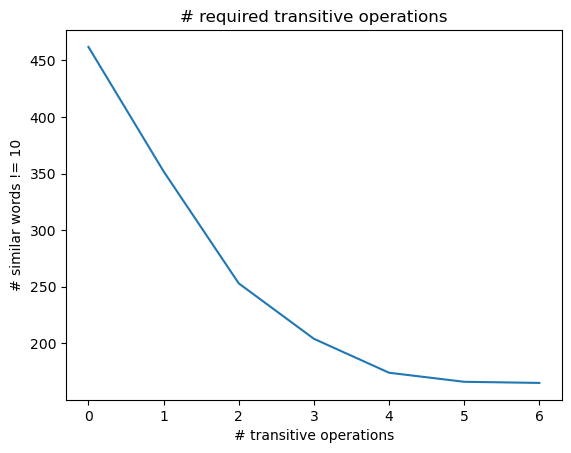

mean ndcg ws:2,vs:50: 0.006785779665144539


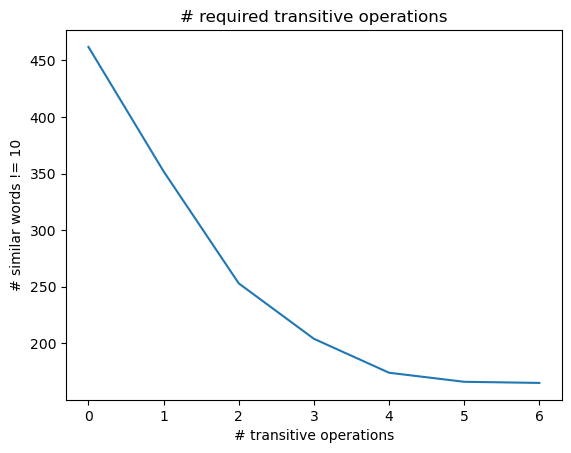

mean ndcg ws:2,vs:100: 0.005750437911715113


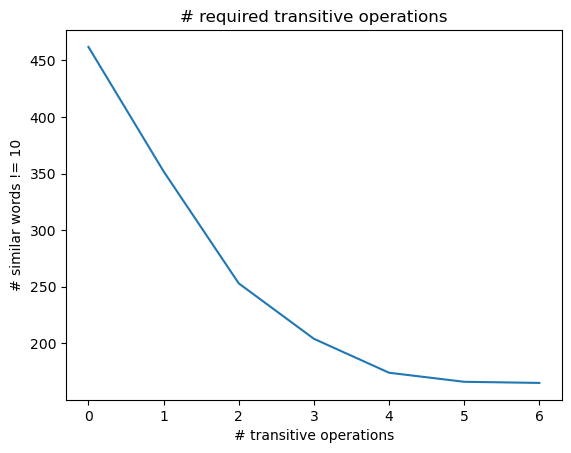

mean ndcg ws:2,vs:300: 0.005416144656508289


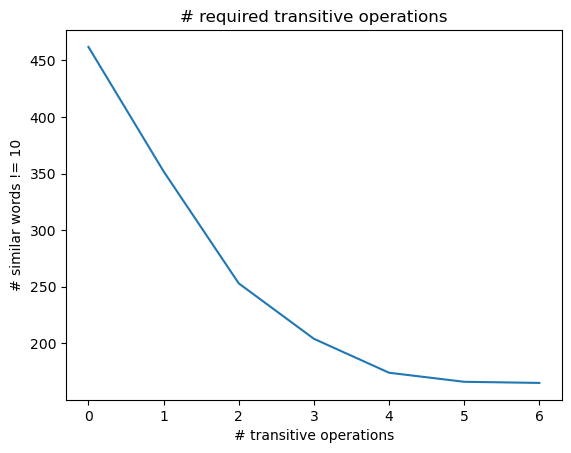

mean ndcg ws:5,vs:10: 0.00395041655433154


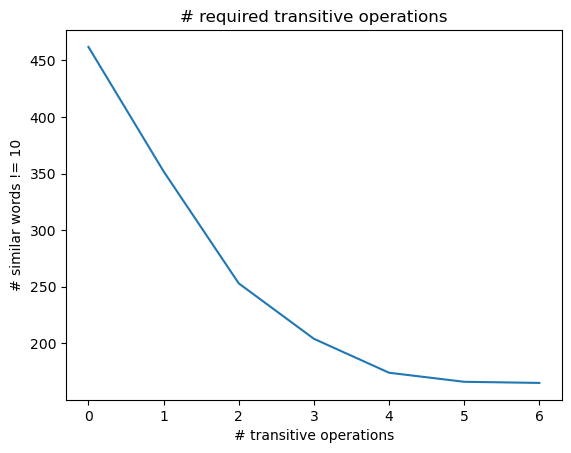

mean ndcg ws:5,vs:50: 0.006334424412370907


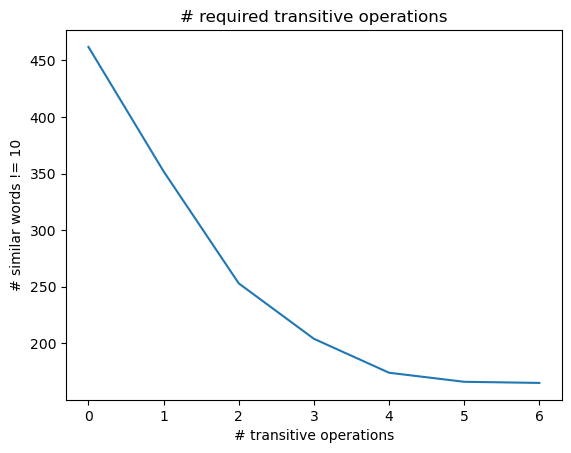

mean ndcg ws:5,vs:100: 0.007142003081838414


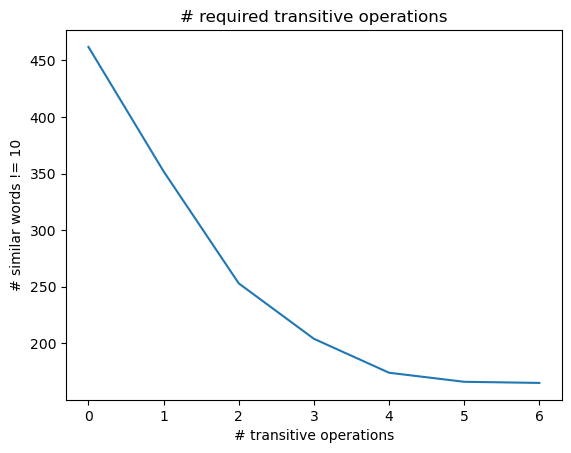

mean ndcg ws:5,vs:300: 0.0048082181533986475


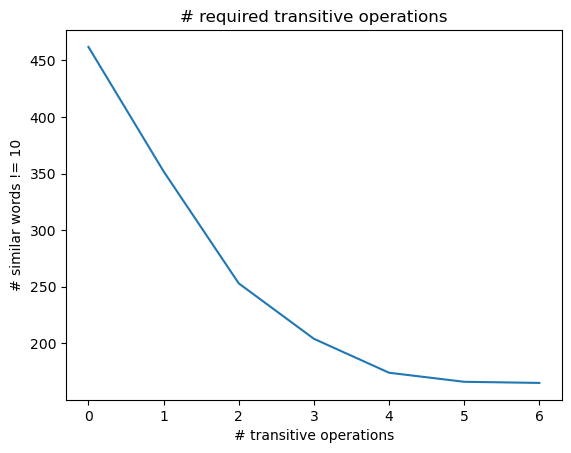

mean ndcg ws:10,vs:10: 0.005856948622437966


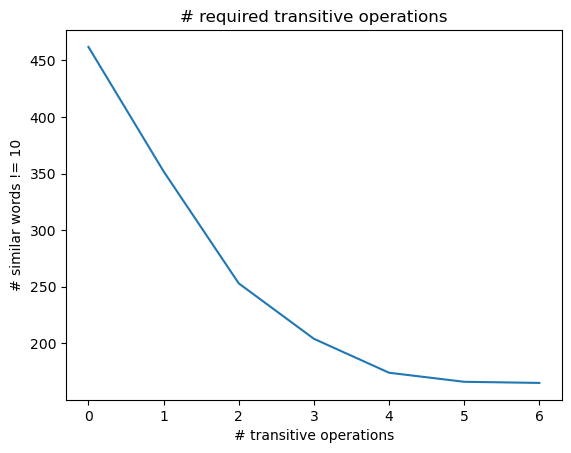

mean ndcg ws:10,vs:50: 0.007356014562962094


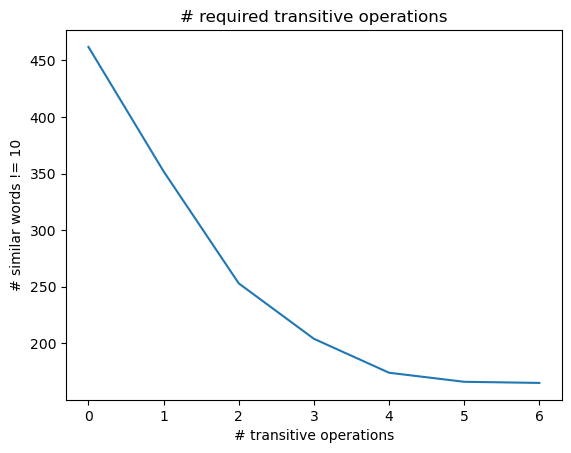

mean ndcg ws:10,vs:100: 0.006286296148859713


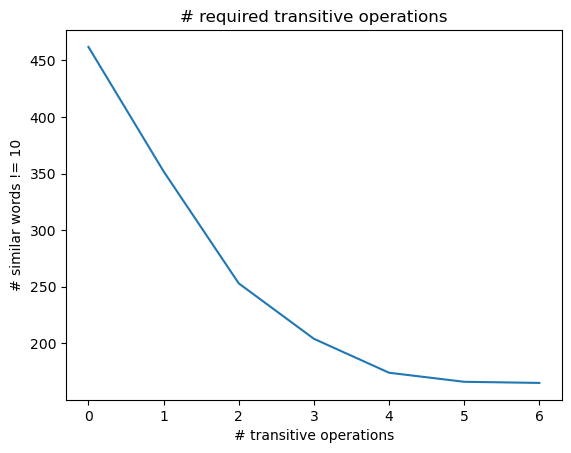

mean ndcg ws:10,vs:300: 0.0054957462164778505


In [58]:
import nltk
nltk.download('brown')
from nltk.corpus import brown, wordnet
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity as cs
import matplotlib.pyplot as plt
import copy
import pytrec_eval
import json
from gensim.models import Word2Vec


################ Dataset ################

#### PyTrec ####
def DictonaryGeneration(model,G):
    M = {}
    for k in model.keys():
        M[k] = {}
        for v in model[k]:
            M[k][v] = 1
    GG = {}
    for k in G.keys():
        GG[k] = {}
        for v in G[k]:
            GG[k][v[1]] = 1
    return M,GG
def DictonaryGenerationW2V(model,G):
    M = {}
    for k in model.keys():
        M[k] = {}
        for v in model[k]:
            M[k][v[0]] = 1
    GG = {}
    for k in G.keys():
        GG[k] = {}
        for v in G[k]:
            GG[k][v[1]] = 1
    return M,GG
brownDS = brown.sents(categories=['news', 'hobbies'])
#### Corpus ####
def data():
    brownDS = brown.sents(categories=['news', 'hobbies'])
    dd =[]
    for i in brownDS:
        dd.append(" ".join(i))
    print(len(dd))
    return dd


#### Ground Truth ####
def notten(a):
  c = 0
  for ii,i in enumerate(a):
    if len(a[i])!=10:
      c+=1
  return c

def transitive(topk,W1,W2,Sim,vocab):
    for word in topk.keys():
        if len(topk[word]) >= 10:
            topk[word] = sorted(topk[word], reverse=True)[:10]
        else:
            topk[word] = sorted(topk[word], reverse=True)
            tw = np.asarray(topk[word])
            addedWords = []
            for sim,word2 in topk[word]:
                if word2 in W1:
                    indices = [i for i, x in enumerate(W1) if x == word2]
                    for ind in indices:
                        if W2[ind] not in tw[:,1] and W2[ind]!=word and W2[ind] not in addedWords:
                            addedWords.append([Sim[ind]*(sim/max(Sim)),W2[ind]])
                if word2 in W2:
                    indices = [i for i, x in enumerate(W2) if x == word2]
                    for ind in indices:
                        if W1[ind] not in tw[:,1] and W1[ind]!=word and W1[ind] not in addedWords:
                            addedWords.append([Sim[ind]*(sim/max(Sim)),W1[ind]])
            addCounter = 0
            addedWords = sorted(addedWords, reverse=True)
            while len(topk[word])<10 and addCounter<len(addedWords):
                topk[word].append(addedWords[addCounter])
                addCounter+=1
    return topk

def transitivityAnalysis(topk,W1,W2,Sim,vocab, render=True):
    lens = []
    lens.append(notten(topk))
    topk = transitive(topk,W1,W2,Sim,vocab)
    while notten(topk) != lens[-1]:
        lens.append(notten(topk))
        topk = transitive(topk,W1,W2,Sim,vocab)
    if render:
        plt.plot(range(len(lens)),lens)
        plt.ylabel('# similar words != 10')
        plt.xlabel('# transitive operations')
        plt.title('# required transitive operations')
        plt.show()
    return topk

def golden_top_K(W1,W2,Sim,vocab):
    topk = {}
    for i in range(len(W1)):
        if W1[i] in vocab:
            first = W1[i]
            second = W2[i]
            if first not in topk.keys():
                topk[first] = [[Sim[i], second]]
            else:
                topk[first].append([Sim[i], second])
        if W2[i] in vocab:
            first = W2[i]
            second = W1[i]
            if first not in topk.keys():
                topk[first] = [[Sim[i], second]]
            else:
                topk[first].append([Sim[i], second])
    return topk
        
################ Models ################
def search(GT, similarities, vocab):
    TOPS = {}
    vv = np.asarray(vocab)
    for i in G.keys():
        if i in vv:
            ind = vocab.index(i)
            simVec = similarities[ind]
            inds = np.flip(simVec.argsort()[-11:])
            inds = np.setdiff1d(inds,ind)
            tops = vv[np.array(inds)]
            TOPS[i] = tops
    return TOPS
def searchW2V(model,G):
    TOPS = {}
    for i in G.keys():
        if model.wv.has_index_for(i):
            sims = model.wv.most_similar(i,topn=10)
            TOPS[i] = sims
    return TOPS

################ Evaluation ################
def evaluatorfunc(model,truth,method):
##    T = np.asarray(topN)
##    q, run = DictonaryGeneration(T[:,:k], M, C)
    if method=='TF-iDF':
        q, run = DictonaryGeneration(model, truth)
    elif method=='Word2Vec':
        q, run = DictonaryGenerationW2V(model, truth)
##    q = model
##    run = truth
    evaluator = pytrec_eval.RelevanceEvaluator(q, {f'ndcg'})
    a = json.dumps(evaluator.evaluate(run), indent=1)
    b = evaluator.evaluate(run)
    return b

################ Main ################
C = data()
f = open("C:\\Users\\SUSHANT\\Desktop\\NLP Project\\SimLex-999.txt", encoding='utf-8')
W1 = []
W2 = []
Sim = []
for line in f.readlines()[1:]:
    fields = line.strip().split('\t')
    W1.append(fields[0].lower())
    W2.append(fields[1].lower())
    Sim.append(float(fields[3]))
f.close()
W1 = np.asarray(W1)
W2 = np.asarray(W2)
Sim = np.asarray(Sim)
method = 'Word2Vec'
if method == 'TF-iDF':
    tfIdfVectorizer=tfidf(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform(C)
    d = pd.DataFrame(tfIdf.T.todense())
    similarities = cs(d)
    keys = tfIdfVectorizer.vocabulary_.keys()
    vocab = []
    for i in keys:
        vocab.append(i)
    gg = golden_top_K(W1,W2,Sim,vocab)
    G = transitivityAnalysis(copy.deepcopy(gg),W1,W2,Sim,vocab,render=False)
    modelTops = search(G, similarities, vocab)
    a = evaluatorfunc(modelTops,G,method)
    d1 = []
    for i in a.keys():
        d1.append(a[i]['ndcg'])
    print(f'mean ndcg:',sum(d1)/len(d1))
    
elif method == 'Word2Vec':
    results = []
    window_size = [1, 2, 5, 10]
    vector_size = [10, 50, 100, 300]
    for ws in window_size:
        for vs in vector_size:
            model = Word2Vec(sentences=brownDS, vector_size=vs, window=ws, workers=4, epochs=10)
            vocab = list(model.wv.index_to_key)
            gg = golden_top_K(W1,W2,Sim,vocab)
            G = transitivityAnalysis(copy.deepcopy(gg),W1,W2,Sim,vocab)
            W2Vtops = searchW2V(model,G)
            results = evaluatorfunc(W2Vtops,G,method)
            d1 = []
            for i in results.keys():
                d1.append(results[i]['ndcg'])
            print(f'mean ndcg ws:{ws},vs:{vs}:',sum(d1)/len(d1))

4
